# Skull Stripping Training & Evaluation

This notebook contains the detailed training and evaluation procedure using our custom library. I ran this on Google Colab for fast training and evaluation using the GPU.

Check the runtime's GPU stats

In [1]:
!nvidia-smi 

Mon Jul 12 15:25:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Mount Google Drive to load our dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Clone the github repository to load the library and required scripts

In [3]:
!git clone https://github.com/aksh-ai/skull-stripping-and-ica.git

Go into the repository's folder and perform all the operations from inside that

In [4]:
import os
os.chdir("skull-stripping-and-ica")

Install all the library requirements

In [5]:
!pip install --quiet --upgrade -r requirements.txt
!unzip -qq '/content/drive/My Drive/data.zip'
!unzip -qq '/content/drive/My Drive/T1w_MRI_test_data.zip'

## Necessary Imports

Import the required libraries. We'll be using [PyTorch](www.pytorch.org) for the Neural Network and its training. Apart from that I'll be using the custom modules from the library that I've created which helps us to complete everything within a few lines of code. Nibabel and Nilearn are used for MRI manipulation and plotting.

In [6]:
import torch
import random
from torch import nn
import numpy as np
import torchvision
import torchio as tio
from lib.data import *
from lib.utils import *
from lib.losses import *
from lib.layers import *
from lib.models import ResidualUNET3D
from lib.runners import *
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from pathlib import Path 
import nibabel as nib
from nilearn import plotting

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Set CuDNN backend as True for faster performance using CuDNN

In [7]:
torch.backends.cudnn.benchmark = True 

## Prepare Dataset

* Create the dataset paths for the images and labels (masks)
* Set the training parameters
* Set directory paths for tensorboard and model checkpoints

In [8]:
# dataset paths
root = Path('data')
images_dir = root / 'images'
labels_dir = root / 'labels'

# training parameters
device= "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 6
patch_size = 64
overlap_size = 16
test_size = 0.2
epochs = 6

# tensorboard and model checkpoint paths
model_dir = 'models'
log_dir = '/content/drive/My Drive/skull_stripping_logs - resUNET3d mse 3'

# create dirs if they don't exist
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# sort the dataset paths
images = sorted(images_dir.glob('*.nii.gz'))
labels = sorted(labels_dir.glob('*.nii.gz'))

### Get Transforms

In the transforms I have included the classes to perform data preprocessing and augmentation.

### Train Transforms

The train transform contains the follwing transforms:

* **Canonical:** This transform reorders the voxels and modifies the affine matrix so that the voxel orientations are in unified format
* **Resample:** Changes voxel spacing by resampling. Ex: 1mm, 2mm, 4mm, etc. Here we are preserving the inital 1mm voxel spacing
* **Random Motion:** Applies random motion to the MRI iamge to simulate real-time motion of MRI
* **Histogram Standardization:** Standardizes histogram and unifies intensity
* **Random Bias Field:** Applies random bias field to the MRI (low frequency signal)
* **ZNormalization:** Normalizes data with mean and standard deviation
* **Random Noise:** Applies random gaussian noise to the image (grainy MRI)
* **Random Flip:** Apllies random flipping to change vertical and horizontal orientations
* **One Of:** To choose any one transforms from a given list randomly
* **Random Affine:** Apply translations to the image to rotate or move the contents of the image within its own space
* **Random Elastic Deformation:** Applies elastic deformation to the MRI which simulates realtime deformation and formation of the image in MRI scans
* **(Optional): One Hot:** To convert the labels to required numbe rof classes or to foreground and background

### Valid Transforms

The valid transform only contains the required preprocessing that can be used for evaluation and inference:

* **Canonical:** This transform reorders the voxels and modifies the affine matrix so that the voxel orientations are in unified format
* **Resample:** Changes voxel spacing by resampling. 1mm, 2mm, 4mm, etc
* **Histogram Standardization:** Standardizes histogram and unifies intensity
* **ZNormalization:** Normalizes data with mean and standard deviation

In [9]:
train_transforms = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(1),
        tio.RandomMotion(p=0.3),
        tio.HistogramStandardization({'mri': np.load('NFBS_histogram_landmarks.npy')}),
        tio.RandomBiasField(p=0.3),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),
        tio.RandomNoise(p=0.49),
        tio.RandomFlip(),
        tio.OneOf({
            tio.RandomAffine(): 0.6,
            tio.RandomElasticDeformation(): 0.4,
        })
    ])

valid_transforms = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(1),
        tio.HistogramStandardization({'mri': np.load('NFBS_histogram_landmarks.npy')}),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean)
    ])

### Load the Data Pipelines

Here I am using the sub-volume (patch) based pipeline that generates subvolumes from the dataset of size (64, 64, 64) with 20% test size for the training and evaluation split with the created training and validation transforms.

In [10]:
training_set, validation_set = load_datasets(images, labels, patch_size=patch_size, volume="patches", test_size=test_size, train_transforms=train_transforms, valid_transforms=valid_transforms, random_state=52)

Volume Mode: PATCHES | Dataset: 125 Images
Training set: 12800 Images
Validation set: 3200 Images


Get the dataloader for the training and validation sets

In [11]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size//2)

Visualize samples from the training set as a grid

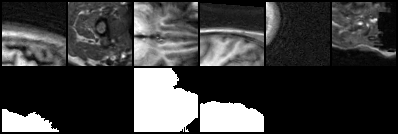

In [12]:
k = (patch_size // 2) + 2
for _ in range(2): batch = next(iter(train_loader))
batch_mri = batch['mri'][tio.DATA][..., k]
batch_label = batch['brain'][tio.DATA][:, :, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=batch_size,
    normalize=True,
    scale_each=True,
)
display.Image(image_path)

## Training

### Model - Residual UNET 3D

I have created a custom image segmentation architecture inspired from Residual Networks and UNET for 3D images. Below is the architecture diagram of the model.

![Residual UNET 3D](images/Residual_UNET_3D.png)

The architecture basically consists of two important blocks:

* Residual Block

![Residual Block](images/residual_block.png)

* Upscaling Block

![Upscaling Block](images/upscale_block.png)

This architecture is a success because of 4 reasons:

* **Residualization -** Residualization is the process of adding source tensor and feature extracted tensor to preserve the features from both source as well as extracted features. In this case, even if the feature extraction is bad in the current layer, residualization allows the next layer to learn features better without subsequential degradation of the network during forward and backward propagation (inspired from ResNet)
* **Optional Skip -** In the network, there is an optional skip connection in the beginning before applying the residual blocks. This can be done or not done based on the complexity of the image as well as inital performance of the model
* **Same Level Skips -** The tensors from downsampling and upsampling layers from the same level are concatenated and processed inorder to get better performance at segmentation (inspired form UNET)
* **Instance Normalization -** Normalization is done for each sample in the batch spatially and independently

Instantiate the model and set parallization for multi-gpu training (if available)

In [13]:
model = ResidualUNET3D(in_channels=1, out_channels=1, optional_skip=True)

if "cuda" in device:
  model = torch.nn.DataParallel(model).to(device)

Get model summary

In [14]:
print(model) 

DataParallel(
  (module): ResidualUNET3D(
    (conv1_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (act1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv1_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (conv1_short): Conv3d(1, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (residual_block1): ResidualBlock3D(
      (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act1): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (norm2): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act2): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), 

In [15]:
total_parameters = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable = total_parameters - trainable
print(f"Number of parameters in the model: {total_parameters}")
print(f"Number of trainable parameters in the model: {trainable}")
print(f"Number of non-trainable parameters in the model: {non_trainable}")

Number of parameters in the model: 23766848
Number of trainable parameters in the model: 23766848
Number of non-trainable parameters in the model: 0


#### Optimization parameters

Adam optimizer with a learning rate of 1e-3 is used with Cosine Annealing scheduler to lower elarning rate after each iteration to prevent overfitting and early convergence. MSE is used the loss function since masks are going to be output by the model. Another good choice would be Dice Loss which can perform better and can be used for class based segmentation too. Tensorboard is used to log the training and validation losses

In [16]:
criterion = StandardSegmentationLoss(loss_type='MSE').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 4e-5)
tensorboard = get_tensorboard(log_dir)

Train the model using the train function from `lib/runners.py`

In [17]:
train_loss, valid_loss = train(train_loader, valid_loader, model, optimizer, criterion, epochs, device, scheduler=scheduler, experiment=tensorboard, verbose=400, model_path=os.path.join(model_dir, 'residual_unet3d_mse_3'))

Epoch [1/6]
Train - Batch [     1/2134] | Loss: 0.279784 | Dice Coefficient: 0.601581 | Jaccard (IoU) Score: 0.430187
Train - Batch [   400/2134] | Loss: 0.026386 | Dice Coefficient: 0.906933 | Jaccard (IoU) Score: 0.829714
Train - Batch [   800/2134] | Loss: 0.023534 | Dice Coefficient: 0.917238 | Jaccard (IoU) Score: 0.847129
Train - Batch [  1200/2134] | Loss: 0.023026 | Dice Coefficient: 0.605413 | Jaccard (IoU) Score: 0.434121
Train - Batch [  1600/2134] | Loss: 0.024687 | Dice Coefficient: 0.912875 | Jaccard (IoU) Score: 0.839716
Train - Batch [  2000/2134] | Loss: 0.011030 | Dice Coefficient: 0.944402 | Jaccard (IoU) Score: 0.894660
Train - Batch [  2134/2134] | Loss: 0.019235 | Dice Coefficient: 0.883509 | Jaccard (IoU) Score: 0.791329
Validation - Batch [     1/1067] | Loss: 0.015608 | Dice Coefficient: 0.813657 | Jaccard (IoU) Score: 0.685856
Validation - Batch [   400/1067] | Loss: 0.015511 | Dice Coefficient: 0.934012 | Jaccard (IoU) Score: 0.876195
Validation - Batch [   8

We can see that the model has been optimized well as it has converged below 1% MSE after just 6 epochs

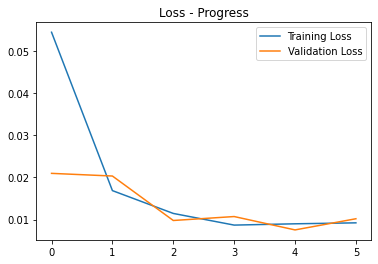

In [18]:
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.title("Loss - Progress")
plt.legend()
plt.show()

Save the model

In [19]:
torch.save(model.state_dict(), os.path.join(model_dir, 'residual_unet3d_MSE_3.pth'))

## Evaluate

Evaluate the model on the validation and test set (slightly different than the training and validation one)

In [20]:
loss, dice, iou = evaluate(valid_loader, model, criterion, device)
print(f"Overall Validation Metrics - Loss: {loss:.6f} Dice: {dice:.6f} IOU: {iou:.6f}")

Overall Validation Metrics - Loss: 0.010058 Dice: 0.911327 IOU: 0.861139


The model has achieved 91 % dice similarity and 86 % Intersection Over Union score which is good

Evaluate the model on the test set by running inference over the test set and visually monitoring the predicted masks as well as skull-stripped image of the brain

In [21]:
test_images = ['T1Img/sub-01/T1w.nii.gz', 'T1Img/sub-02/anat_img.nii.gz', 'T1Img/sub-03/T1w MRI.nii', 'T1Img/sub-04/T1w MRI.nii', 'T1Img/sub-05/T1w MRI.nii']
saved_imgs = []

Test set evaluation
Image: T1Img/sub-01/T1w.nii.gz


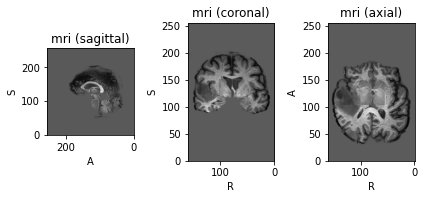

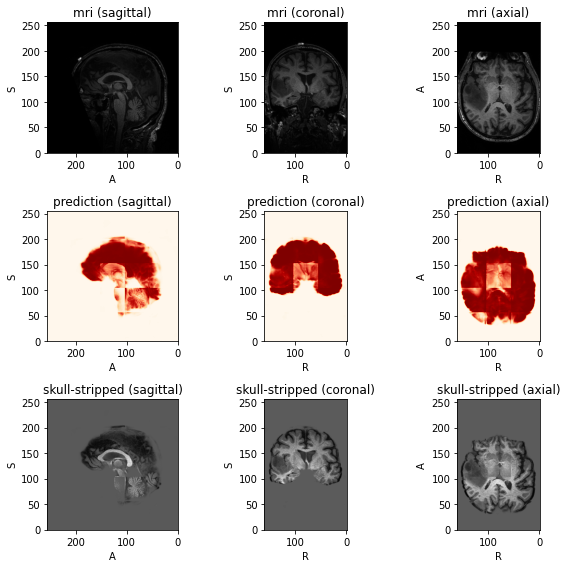

Image: T1Img/sub-02/anat_img.nii.gz


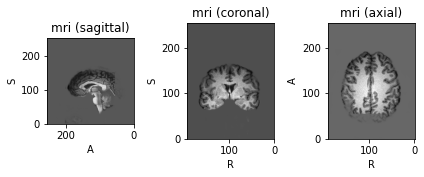

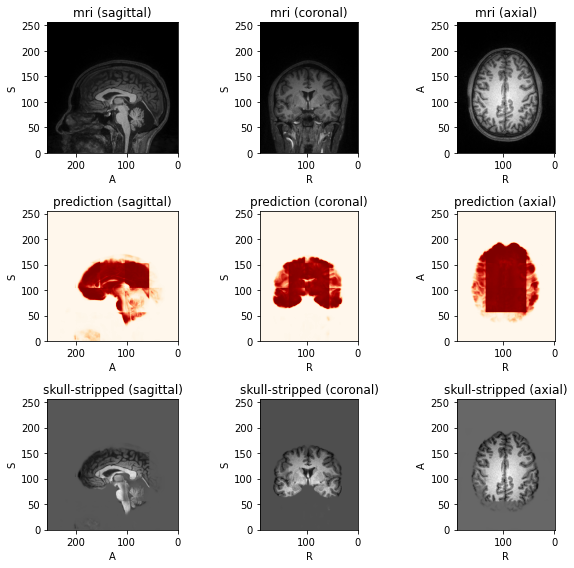

Image: T1Img/sub-03/T1w MRI.nii


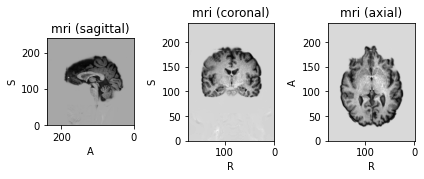

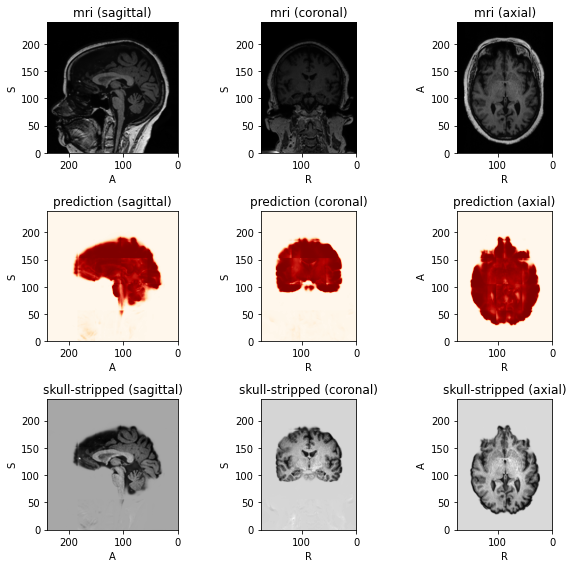

Image: T1Img/sub-04/T1w MRI.nii


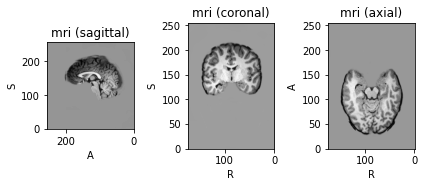

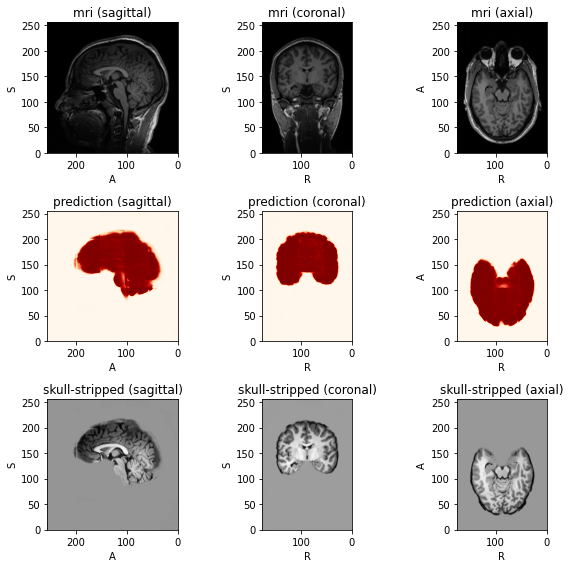

Image: T1Img/sub-05/T1w MRI.nii


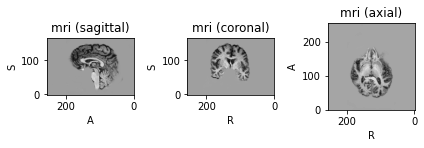

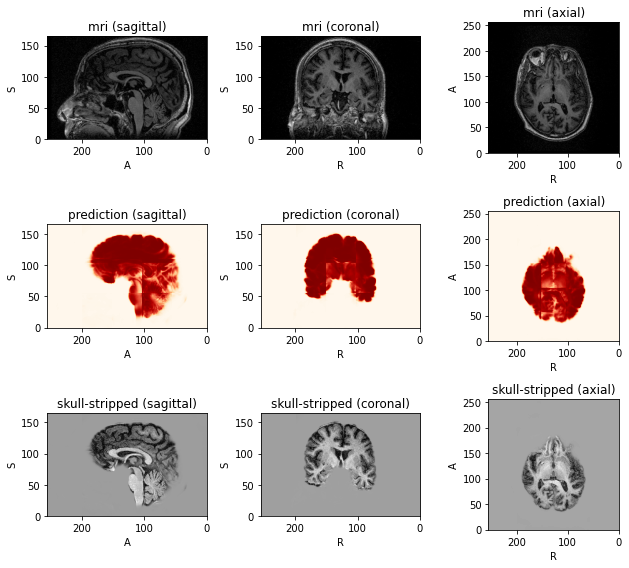

In [22]:
print("Test set evaluation")
for image in test_images:
  print(f"Image: {image}")
  save_path = image.split('.')[0] + '_skull_stripped.nii.gz'
  saved_imgs.append(save_path)

  original, stripped, mask = infer(image, save_path, model, patch_size=patch_size, overlap=overlap_size, batch_size=batch_size, device=device, visualize=True, return_tensors=True)

  subject = tio.Subject(mri=tio.ScalarImage(tensor=original))
  subject.add_image(tio.ScalarImage(tensor=mask), 'prediction')
  subject.add_image(tio.ScalarImage(tensor=stripped), 'skull-stripped')
  subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'OrRd'})

We can see that the model has performed really well at skull-stripping. Plot a skull-stipped test image using nilearn's plotting


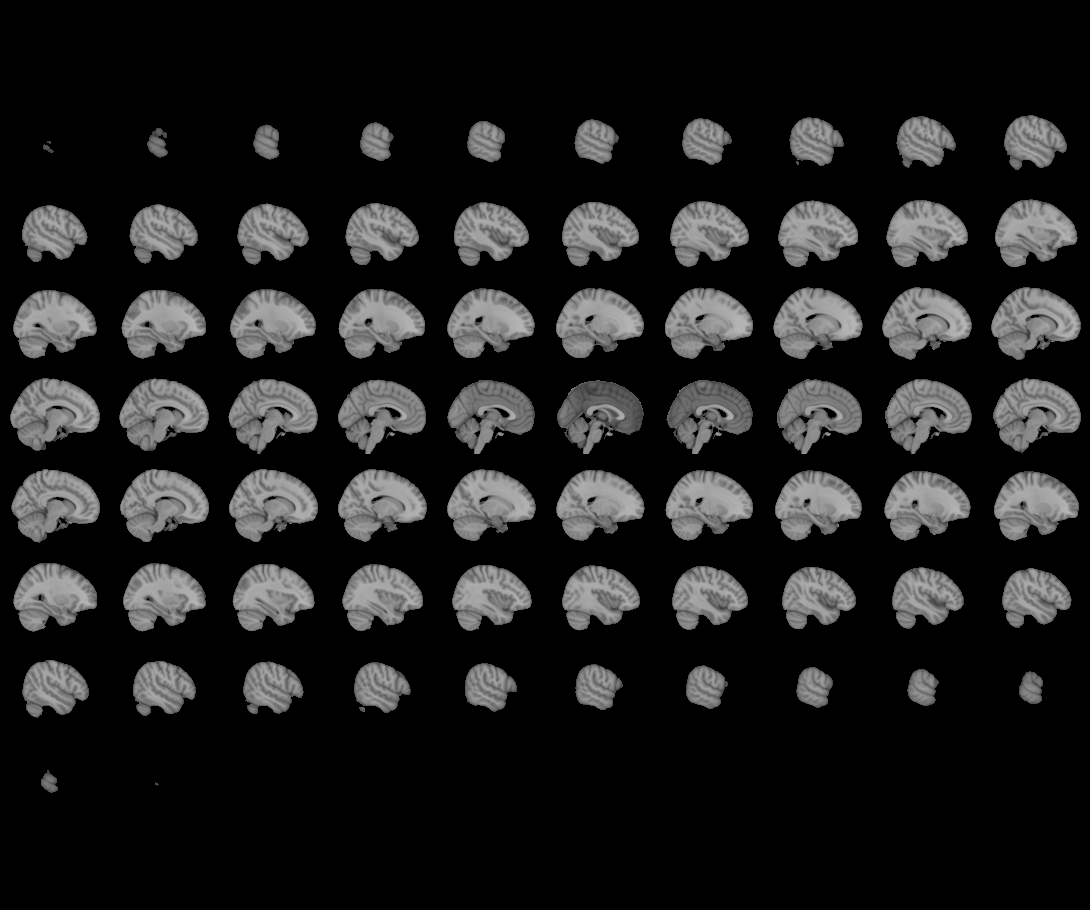
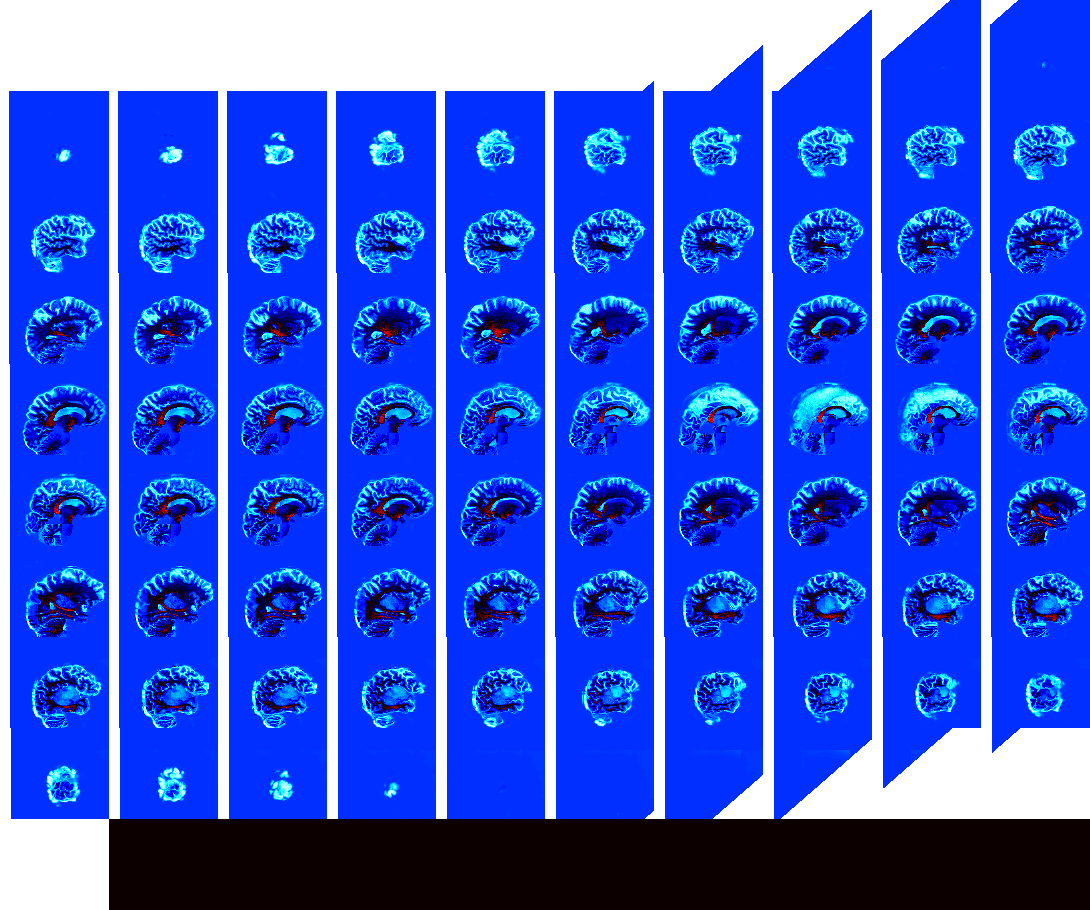

In [23]:
plotting.view_img(saved_imgs[0])

Save the trained model's weights which can be loaded and used for inference

In [24]:
torch.save(model.state_dict(), '/content/drive/My Drive/residual_unet3d_MSE_3.pth')